# Lab Session #5
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font>  César Zapata - 02213600
<br>
<font color=blue>Academic Year:</font> 2022-2023

# Module 3: Brunel network

In this practical, you will simulate a network of sparsely connected identical Leaky-Integrate-and-Fire neurons. 

This model is based on the paper by [Brunel 2000](https://link.springer.com/article/10.1023/A:1008925309027) and is also discussed in [Neuronal Dynamics](http://neuronaldynamics.epfl.ch), see eg. Figure 13.7. 

We will show that a large network of neurons consisting of a group of excitatory and a group of inhibitory neurons that receive external input is capable of producing a rich dynamics. The parameters that we will vary to trigger different states are (1) the driving frequency of the external population and (2) the relative strength of inhibition vs excitation (g). 

To do so, we will follow two strategies both relying on the BRIAN package: the first strategy is to create our own network from scratch. This will allow you to get acquainted with the BRIAN package and will prepare you for the second strategy. Here, you will use a pre-defined spiking network (included in the BRIAN package), but you will have to make sure you understand its input and outputs in order to induce the correct behaviour. 


We start by ensuring all packages are loaded. Make sure to have installed the [Brian Package](https://briansimulator.org/) 

In [16]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools, spike_tools
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

## Step 1.1. Initialising the NeuronGroup instance

We start by defining a NeuronGroup instance. You can find the documentation [here](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.groups.neurongroup.NeuronGroup.html) 

A NeuronGroup instance takes as input the number of neurons, the dynamics of a single neuron 'model', the length of the refractory period and the integration method. Note that initialising the NeuronGroup will not yet run the simulation. Running the simulation will be done in the upcoming blocks once we have added all details to the network. 

The input parameters of the NeuronGroup instance should be: 
- number of neurons: N_Excit (4000) +N_Inhib (1000)
- the model should model the LIF dynamics
- the model should reset at a threshold v = v_reset (10 mV)
- the neurons should have an absolute refractory period (2ms)
- integration method should be linear

What is the default firing threshold? 

In [51]:
b2.start_scope()

N_Excit = 4000
N_Inhib = 1000
abs_refractory_period = 2 * b2.ms
v_rest = 0. * b2.mV
membrane_time_scale = 20 * b2.ms
firing_threshold = 20 * b2.mV
b2.defaultclock.dt = 0.1 * b2.ms
v_reset = 10 * b2.mV
tau = 20 *b2.ms

print(f"default firing threshold: {LIF_spiking_network.FIRING_THRESHOLD}")

lif_dynamics = """ dv/dt = -v / tau : volt (unless refractory)
v0 : volt """

network = NeuronGroup(
    N_Excit+N_Inhib, model=lif_dynamics,
    threshold='v > firing_threshold', refractory=abs_refractory_period,
    method="linear",reset='v=v_reset')

print(network)
print(network.v)

default firing threshold: 0.02
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
<neurongroup.v: array([0., 0., 0., ..., 0., 0., 0.]) * volt>


<div class="alert alert-success">
<span style="color:black">

**A1.1 Answer** 

\begin{tcolorbox}[colback=green!5]
    
The default firing threshold is 20mV

\end{tcolorbox}
    
</span>

## Step 1.2. Add network structure
Now that we have created a group of neurons, we will define how they are connected. In order to connect neurons to each other, we first need to distinguish the two neuronal populations (the excitatory and inhibitory population). In order to define the first N_Excit neurons to be excitatory and the remaining part to be inhibitory, you can simply use the following code snippet. 

In [18]:
excitatory_population = network[:N_Excit]
inhibitory_population = network[N_Excit:]

Now, we need to define two types of synapses: excitatory and inhibitory synapses. Allow for a synaptic delay of 1.5*b2.ms and use a random connection probability of 0.1. You can find the documentation [here](https://brian2.readthedocs.io/en/stable/user/synapses.html) 
In order to follow the notations in the book, please use following notation and default values: 

What is the "target" network? 

In [19]:
w0 = 0.1*b2.mV
g = 4.0
J_excit = w0
J_inhib = -g*w0
synaptic_delay = 1.5*b2.ms
connection_probability = 0.1

# trying this for the on_pre https://neurostars.org/t/create-excitatory-and-inhibitory-populations-in-brian2/16454
# https://brian2.readthedocs.io/en/stable/examples/frompapers.Brunel_2000.html

exc_synapses = Synapses(excitatory_population, target=network, on_pre="v += (rand() < connection_probability) * J_excit", delay=synaptic_delay)
exc_synapses.connect(p=connection_probability)

inhib_synapses = Synapses(inhibitory_population, target=network, on_pre="v += (rand() < connection_probability) * J_inhib", delay=synaptic_delay) # if w is negative then it is inhibitory
inhib_synapses.connect(p=connection_probability)

<div class="alert alert-success">
<span style="color:black">

**A1.2 Answer** 

\begin{tcolorbox}[colback=green!5]
    
The targert neuron is the totality of the neuron group model, including excitatory and inhibitory neurons. This way every single modeled neuron has a change of being affected. However, a neuron will only be affected if the conection probability's threshold is surpassed for that specific synapse. The effect on the neuron then will depend on the nature of the neuron sending the impulse, if it is inhibitory or excitatory. 

\end{tcolorbox}
    
</span>

## Step 1.3. Enter external Poisson input
Next, you can excite the network through an externally applied Poisson input, by using [Poisson Input](https://brian2.readthedocs.io/en/stable/reference/brian2.input.poissoninput.PoissonInput.html). Start with N = 1000 external Poisson neurons at an input rate of 13 Hz with a connectivity strength w = w0. 



In [20]:
poisson_input_rate = 13*b2.Hz
N_extern = 1000
w_external = w0; 
external_poisson_input = PoissonInput(target=network, target_var='v', N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)


## Step 1.4. Add monitors 
In the final step before running the simulation we will add some monitors that allows us to assess the simulated network once the simulation has finished. In order to do so, we will monitor a random selection of 100 neurons and the use the [PopulationRateMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html), [SpikeMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html) and [StateMonitor](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.statemonitor.StateMonitor.html). 

Sample 200 of all neurons involved. 

In [21]:
monitored_subset_size = 200 
idx_monitored_neurons = sample(range(0, monitored_subset_size), 100)

rate_monitor = PopulationRateMonitor(network)
spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)


## Step 1.5. Run the simulation
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted. 


In [22]:
sim_time=500.*b2.ms
b2.run(sim_time)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "v += J_excit * (rand() < connection_probability) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "v += J_inhib * (rand() < connection_probability) (in-place)"
 [brian2.codegen.generators.base]


(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ff955ba128>)

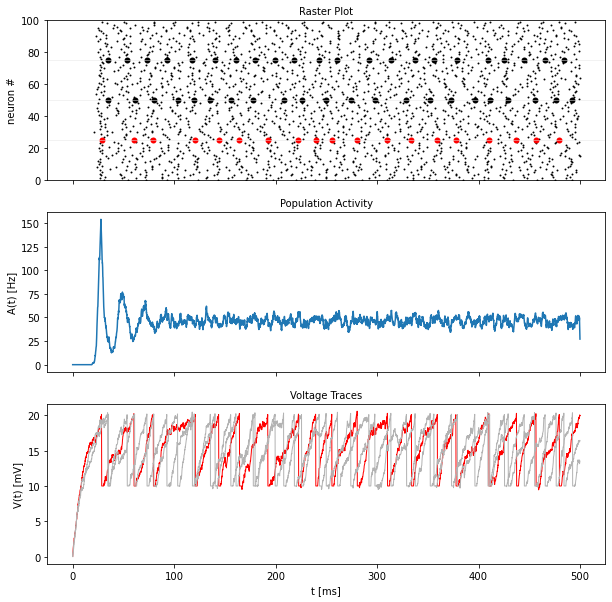

In [23]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=idx_monitored_neurons,\
                                 figure_size=(10, 10), t_min=0.*b2.ms)


Access the data in rate_monitor, spike_monitor, voltage_monitor

First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window. 

You can the time axis from rate_monitor.t

In [24]:
ts = rate_monitor.t / b2.ms
print(ts.shape)
print(rate_monitor.rate.shape)
t_min = 350; t_max = 500 

(5000,)
(5000,)


Now, vary the window width across which the rate is averaged and write down your observations (do plot!). 



mean window 1: 46.2 Hz
mean window 2: 46.019555555555556 Hz
mean window 3: 45.795735973597345 Hz
mean window 4: 45.40367495854062 Hz


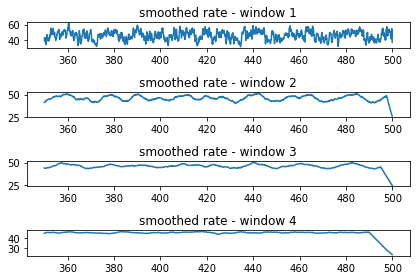

In [25]:
window_widths = [0.5,5,10,20]*b2.ms;

for i in range(0,4):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(4,1,i+1)
    plt.tight_layout()
    plt.plot(ts[-1500:],smoothed_rates[-1500:])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[-1500:])} Hz")

Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  

In [26]:
eventtrains = spike_monitor.event_trains(); # dict -> keys: 0 to 5000 (0.1 ms), values: events in that window of time
diff = np.zeros(5000)

for i in range(5000):
    diff[i] = np.mean(np.diff(eventtrains[0])) # take the mean of the ISIs in an interval of time of 0.1ms
    
mean_ISI = np.mean(diff) # the mean of all 500ms 
print(f"mean ISI: {mean_ISI} ms\nmean firing rate: {1 / mean_ISI} Hz") # mean firing rate is the reciprocal of the mean ISIs 

mean ISI: 0.02194761904761905 ms
mean firing rate: 45.56302885658494 Hz
mean ISI last 150ms: 0.021947619047619042 ms
mean firing rate last 150ms: 45.56302885658496 Hz


<div class="alert alert-success">
<span style="color:black">

**A1.5 Answer** 

\begin{tcolorbox}[colback=green!5]

It can be infered from the Raster plot and Population activity plot that this model has a seemingly regular and synchronized firing, with a group o neurons firing very close to each other every time. It does not look as a stochastic behaviour. The signal presents a high amplitude at the begining of the simulation and then stabilizes around 50Hz.
    
Observing the mean firing frequencies provided by the smoothing windows, we can see that, just as we thought, the firing rate is much slower than the previous examples, with a value very close to 20Hz.
    
The rate_monitor.rate consists of an array of 5000 elements that are equivalent to the firing rate at the given time (0.1ms represented on each value).
    
The spike_monitor is a Dictionary with 5000 keys (again, one for each 0.1ms), where the values for each key are stored in arrays of all the events that occured during that period of time.

With this information, we could calculate the mean time between two subsequent spikes by taking the average of the interspike intervals for each 0.1ms and then averaging those values so we get the mean for the whole 500ms. This returned a value of 0.02129ms (or 21.29us) as the mean time between two subsequent spikes.
We can also corroborate this value by taking the reciprocal of the mean ISIs to see what the mean firing rate would be in that case. The mean firing rate calculated was 45.56Hz, which is very close to the one found previusly for the simulation.

\end{tcolorbox}
    
</span>

# 2. The pre-implemented Brunel network

Import the LIF_spiking_network function from neurodynex3.brunel_model and use this function to simulate a network consisting of 10000 excitatory neurons, 2500 inhibitory neurons and 1000 external neurons. 

Further, 
- w0 = 0.1 mV
- total simulated time of 500 ms
- the membrane time scale can be put to default (LIF_spiking_network.MEMBRANE_TIME_SCALE)
- the same goes for the firing threshold (LIF_spiking_network.FIRING_THRESHOLD)
- monitored_subset = 50
- synaptic delay is 1.5ms 

We will vary two parameters: g (an input parameter to simulate_brunel_network) and, second, the firing frequency of the external neurons $\nu_{extern}$. The latter should be expressed as a ratio multiplied with $\nu_{threshold}$. The frequency $\nu_{threshold}$ is the minimal poisson rate in the external neuronal population required to elicit firing in the network in the absence of any feedback. 

According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 

\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}

Does this expression make sense? 

For starters, you can use g=6 and $\nu_{extern} = 4\nu_{threshold}$

Calculate $\nu_{threshold}$ in function of the parameters mentioned above and the corresponding $\nu_{extern}$. And run the simulation. Make sure to output rate_monitor, spike_monitor, voltage_monitor and monitored_spike_idx.

Make sure to start each simulation with a "b2.start_scope()" statement. 

In [27]:
from neurodynex3.brunel_model import LIF_spiking_network
b2.start_scope()


In [28]:
theta = LIF_spiking_network.FIRING_THRESHOLD # firing_threshold
w0 = 0.1 * b2.mV
N_excit = 10000
N_inhib = 2500
N_ext = 1000
tau = 20 *b2.ms

v_threshold = theta / (N_ext * w0 * tau)
v_extern = 4 * v_threshold # v_extern = poisson_input_rate

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=N_excit, N_Inhib=N_inhib, N_extern=N_ext, w0=w0, g=6, synaptic_delay=1.5*b2.ms, sim_time=500.*b2.ms, monitored_subset_size=50, poisson_input_rate=v_extern)

Plot the output using "plot_network_activity", make sure to add the "t_min" and "t_max" parameter and increase the figure size to figure_size=(10,10). 

INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ff904cb0b8>)

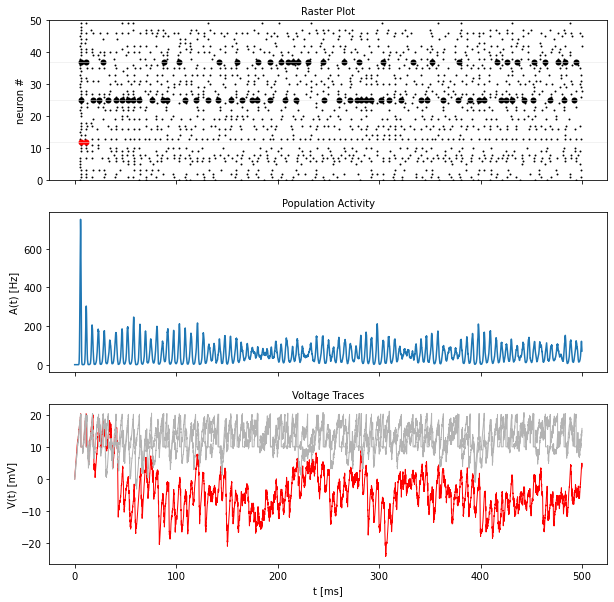

In [29]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=0.*b2.ms,\
                                 figure_size=(10, 10))

The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 


INFO       width adjusted from 0.5 ms to 0.55 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 5. ms to 5.05 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 20. ms to 20.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(10000,)
mean window 1: 57.84378181818182 Hz
mean window 2: 58.11409108910891 Hz
mean window 3: 58.340684289276815 Hz


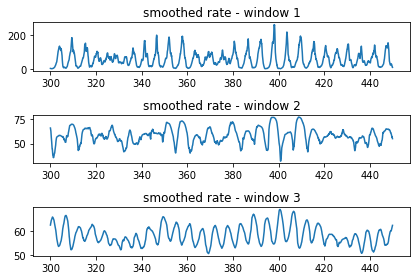

In [31]:
ts = rate_monitor.t / b2.ms
print(ts.shape)
t_min = 300; t_max = 450 

window_widths = [0.5, 5, 20]*b2.ms;

for i in range(0,3):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    plt.plot(ts[6000:-1000],smoothed_rates[6000:-1000])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[6000:-1000])} Hz")

Next, we want to assess the global frequency content in rate_monitor. We know that if we have a time signal of 0.5 seconds, the maximal frequency resolution is 2 Hz. Be aware that Welch' method as implemented will chop the data in different pieces (to enable the averaging of the spectrum) yielding a smaller frequency resolution.  

Start by smoothing the rate with a window of 0.5 ms and calculate the spectrum using [signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). What is the sampling frequency fs? 

Plot the spectrum. What is the frequency resolution (look at np.diff(f)[0]). Can you explain how signal.welch arrives at this frequency resolution if you know that it - by default - includes 256 samples and if you check the integration time constant (typically 0.05 ms, but check b2.defaultclock.dt) that you used for the simulation? 

What happens if you impose nperseg = 256*8? 

What happens if you impose nfft = 10000 ? (Answer: you interpolate the spectrum). 

20000
freq_res 256: 78.125 Hz
freq_res 256*8: 9.765625 Hz
freq_res 256*8, nfft=10000: 2.0 Hz
default clock: 5e-05


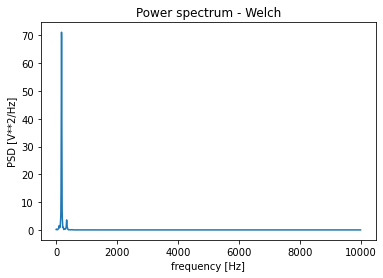

In [36]:
from scipy import signal

smoothed_rates = rate_monitor.smooth_rate(window='gaussian', width=0.5*b2.ms)

fs = 2 * len(ts) # nyquist criterium
print(fs)

f, Pxx_den = signal.welch(smoothed_rates, fs, nperseg=256*8, nfft=10000)
f_0, Pxx_den_0 = signal.welch(smoothed_rates, fs)
f_1, Pxx_den_1 = signal.welch(smoothed_rates, fs, nperseg=256*8)

#print(max(Pxx_den)) # -> 81

print(f"freq_res 256: {np.diff(f_0)[0]} Hz")
print(f"freq_res 256*8: {np.diff(f_1)[0]} Hz")
print(f"freq_res 256*8, nfft=10000: {np.diff(f)[0]} Hz")
print(f"default clock: {b2.defaultclock.dt}") # 0.05ms


plt.plot(f, Pxx_den)
plt.title("Power spectrum - Welch")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]') #power spectral density
plt.show()

We will now use the machinery provided by BRIAN to calculate and plot the power spectrum. BRIAN takes a slightly different approach. BRIAN starts from a desired frequency resolution, a desired number of windows over which the spectrum should be averaged and an initial time segment that should be ignored. Based on these desiredata, the minimal simulation length is calculated. 

Example: if we want a frequency resolution of 5 Hz, we need time windows of 200 ms. If we assume non-overlapping time windows and a number of averages the total simulated signal should be k*200ms. 

In this case, we have simulated 0.5 seconds of data. If we aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz, what is then the maximal number of windows we can include? 

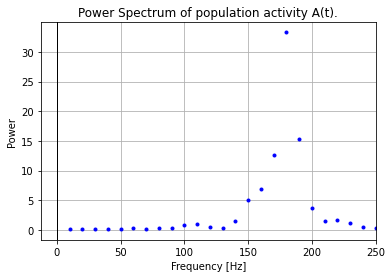

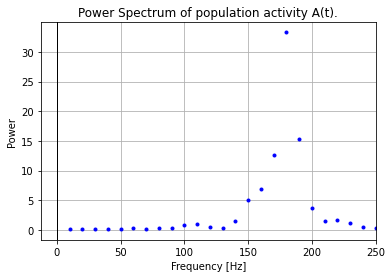

In [35]:
delta_f = 10*b2.Hz; 
k = 4 #trial and error 1,2,3,4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = \
    spike_tools.get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**2 Answer** 

\begin{tcolorbox}[colback=green!5]
    
The Raster plot and Population Activity plot show a very regular signal that stabilizes around 200Hz and has a very uniform activity pattern, it can be almost described as a repeating one in some windoes of time.
    
The mean of smoothed_rate across a time window between 300 and 450ms is 58Hz, which comes very close to the SI, fast firing rate, just between the Simulation and the theory values (60.7 and 55.8 respectively).
    
In order to use the Welch method, we require the nyquist frequency, which corresponds to the highest frequency that a sampled data system can reproduce without error. 
The frequency resolution is equivalent to the sampling rate divided by the FFT size, and we can clearly see how it behaves in the three different calculations made:
    - 256 samples resolution: 78.125Hz 
    - 2048 samples resolution: 9.77Hz (dramatically increase on resolution) 
    - 2048 samples with 10000 FFT resolution: 2Hz (maximum resolution)

Always have in mind that increasing the FFT size will also take longer to compute.
    
For the value of k, 4 windows was the highest number we can include before an error occurs.
    
\end{tcolorbox}
</span>

## 3 Explore the dynamics. 
Repeat the steps in ##2 for the following set of parameters: 

(A) g = 3, $\nu_{extern}/\nu_{threshold} = 2$ 

(B) g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

(C) g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Describe what you observe.

## A : g = 3, $\nu_{extern}/\nu_{threshold} = 2$

Default tiring threshold: 0.02


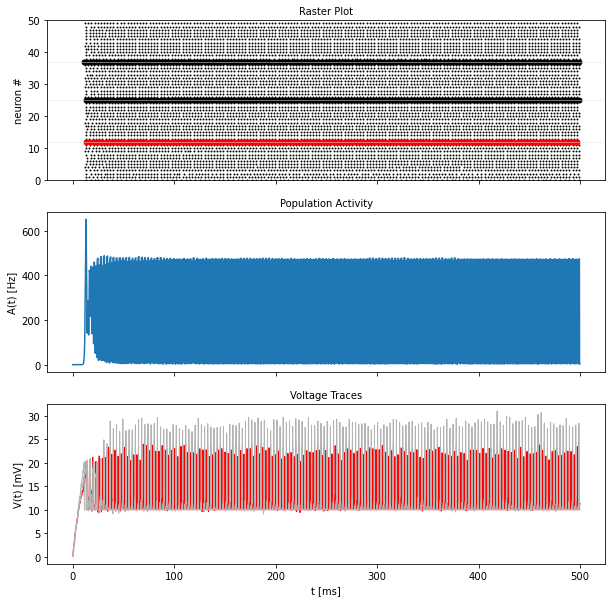

ts shape: (10000,)
mean window 1: 321.48896969696966 Hz
mean window 2: 320.62713663366327 Hz
mean window 3: 320.7714473815461 Hz


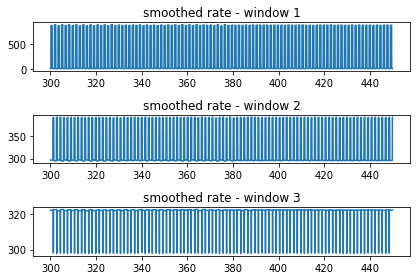

fs welch - nyquist: 20000
freq_res: 2.0


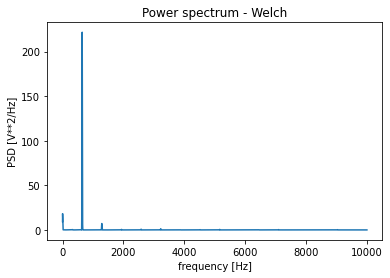

In [38]:
b2.start_scope()


#                                              Defining model

theta = LIF_spiking_network.FIRING_THRESHOLD # firing_threshold
print(f"Default tiring threshold: {theta}")
w0 = 0.1 * b2.mV
N_excit = 10000
N_inhib = 2500
N_ext = 1000
tau = 20 *b2.ms

v_threshold = theta / (N_ext * w0 * tau)
v_extern = 2 * v_threshold # v_extern = poisson_input_rate

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=N_excit, N_Inhib=N_inhib, N_extern=N_ext, w0=w0, g=3, synaptic_delay=1.5*b2.ms, sim_time=500.*b2.ms, monitored_subset_size=50, poisson_input_rate=v_extern)


#                                               Plotting
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=0.*b2.ms,\
                                 figure_size=(10, 10))

plt.show()

#                                              Smoothing
ts = rate_monitor.t / b2.ms
print(f"ts shape: {ts.shape}")
t_min = 300; t_max = 450 

window_widths = [0.5, 5, 20]*b2.ms;

for i in range(0,3):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    plt.plot(ts[6000:-1000],smoothed_rates[6000:-1000])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[6000:-1000])} Hz")
plt.show()

    
#                                           Welch - power spectrum  
smoothed_rates = rate_monitor.smooth_rate(window='gaussian', width=0.5*b2.ms)

fs = 2 * len(ts) # nyquist criterium
print(f"fs welch - nyquist: {fs}")

f, Pxx_den = signal.welch(smoothed_rates, fs, nperseg=256*8, nfft=10000)

#print(max(Pxx_den)) # -> 81

print(f"freq_res: {np.diff(f)[0]}")

plt.plot(f, Pxx_den)
plt.title("Power spectrum - Welch")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]') #power spectral density
plt.show()

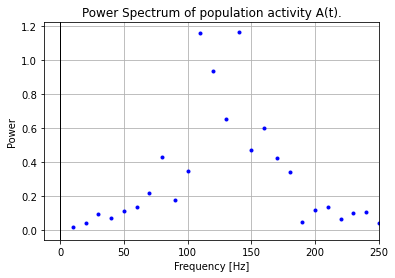

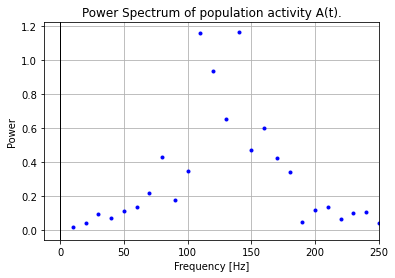

In [44]:
#                                             Power spectrum - population activity
delta_f = 10*b2.Hz; 
k = 4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = \
    spike_tools.get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**3A Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
The mean firing rate is extremely high compared to the previous exercise, there is a very clear behaviour/pattern that can be analyzed in the raster plot and the population activity. It can be seen as very rapid short bursts of spiking that are very close to each other, almost as if the neurons were continuously firing. 
The behaviour can be explained possibly because the g value is too small for the given external threshold and the neurons in our network are being overstimulated by external ones.
    
The power spectrum shows very low power compared to the previous exercise, a full order of magnitude smaller, and with a peak in frequencies between 100 and 190Hz. 
    
\end{tcolorbox}

</span>

## B : g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

Default tiring threshold: 0.02


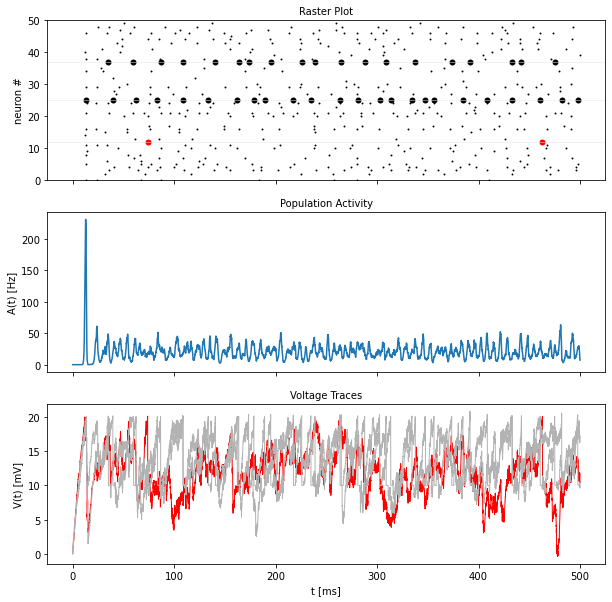

ts shape: (10000,)
mean window 1: 20.471224242424242 Hz
mean window 2: 20.4064 Hz
mean window 3: 20.27187497921862 Hz


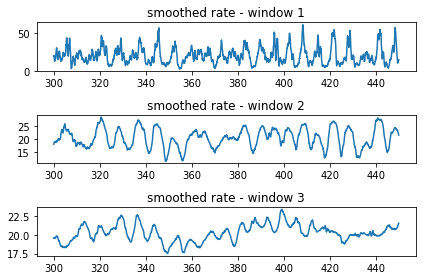

fs welch - nyquist: 20000
freq_res: 2.0


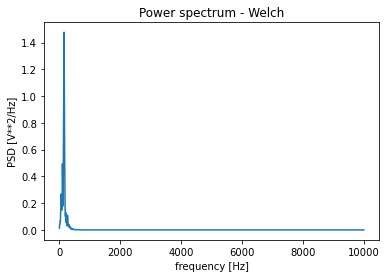

In [45]:
b2.start_scope()


#                                              Defining model

theta = LIF_spiking_network.FIRING_THRESHOLD # firing_threshold
print(f"Default tiring threshold: {theta}")
w0 = 0.1 * b2.mV
N_excit = 10000
N_inhib = 2500
N_ext = 1000
tau = 20 *b2.ms

v_threshold = theta / (N_ext * w0 * tau)
v_extern = 2 * v_threshold # v_extern = poisson_input_rate

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=N_excit, N_Inhib=N_inhib, N_extern=N_ext, w0=w0, g=6, synaptic_delay=1.5*b2.ms, sim_time=500.*b2.ms, monitored_subset_size=50, poisson_input_rate=v_extern)


#                                               Plotting
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=0.*b2.ms,\
                                 figure_size=(10, 10))

plt.show()


#                                              Smoothing
ts = rate_monitor.t / b2.ms
print(f"ts shape: {ts.shape}")
t_min = 300; t_max = 450 

window_widths = [0.5, 5, 20]*b2.ms;

for i in range(0,3):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    plt.plot(ts[6000:-1000],smoothed_rates[6000:-1000])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[6000:-1000])} Hz")
plt.show()

    
#                                           Welch - power spectrum  
smoothed_rates = rate_monitor.smooth_rate(window='gaussian', width=0.5*b2.ms)

fs = 2 * len(ts) # nyquist criterium
print(f"fs welch - nyquist: {fs}")

f, Pxx_den = signal.welch(smoothed_rates, fs, nperseg=256*8, nfft=10000)

#print(max(Pxx_den)) # -> 81

print(f"freq_res: {np.diff(f)[0]}")

plt.plot(f, Pxx_den)
plt.title("Power spectrum - Welch")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]') #power spectral density
plt.show()

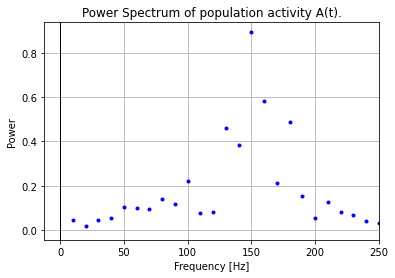

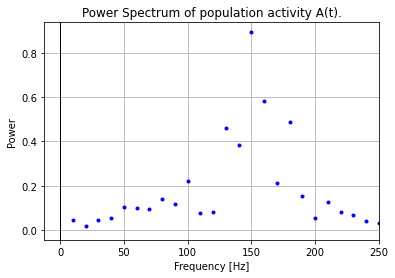

In [46]:
#                                             Power spectrum - population activity
delta_f = 10*b2.Hz; 
k = 4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = \
    spike_tools.get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**3B Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
It can be infered from the Raster plot and Population activity plot that this model has a much lower firing frequency. A big part of the neurons fire at the same time at the begining and then the evoked signal stabilizes around 50Hz. The neurons do not seem to be firing following a specific pattern. The events are not easily predictabe.
    
Observing the mean firing frequencies provided by the smoothing windows, we can see that, just as we thought, the firing rate is much slower than the previous examples, with a value very close to 20Hz.
    
Here, the power spectrum is very condensed close to the 150Hz mark, with no other notable peaks. 
    
\end{tcolorbox}

</span>

## C : g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Default tiring threshold: 0.02


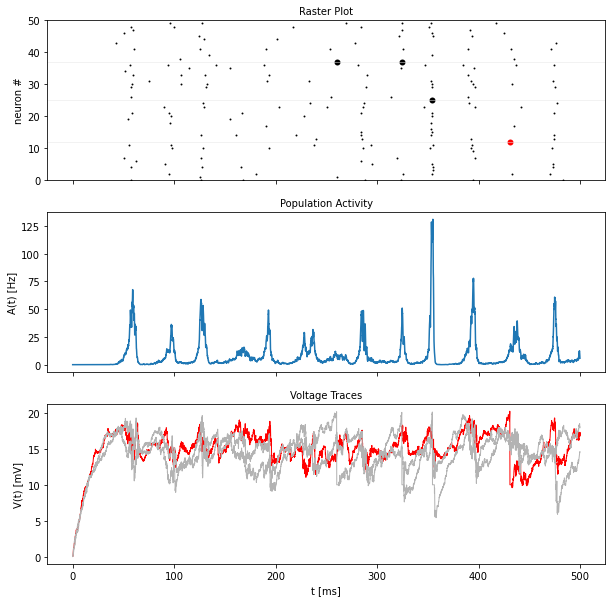

ts shape: (10000,)
mean window 1: 9.280727272727272 Hz
mean window 2: 9.274455445544556 Hz
mean window 3: 9.216960266001662 Hz


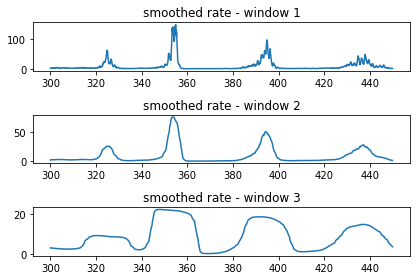

fs welch - nyquist: 20000
freq_res: 2.0


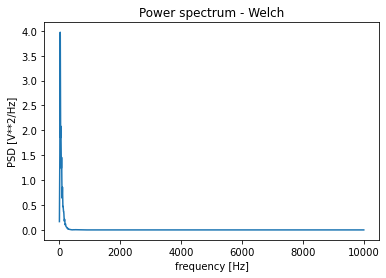

In [49]:
b2.start_scope()


#                                              Defining model

theta = LIF_spiking_network.FIRING_THRESHOLD # firing_threshold
print(f"Default tiring threshold: {theta}")
w0 = 0.1 * b2.mV
N_excit = 10000
N_inhib = 2500
N_ext = 1000
tau = 20 *b2.ms

v_threshold = theta / (N_ext * w0 * tau)
v_extern = 0.95 * v_threshold # v_extern = poisson_input_rate

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=N_excit, N_Inhib=N_inhib, N_extern=N_ext, w0=w0, g=4.5, synaptic_delay=1.5*b2.ms, sim_time=500.*b2.ms, monitored_subset_size=50, poisson_input_rate=v_extern)


#                                               Plotting
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=0.*b2.ms,\
                                 figure_size=(10, 10))
plt.show()


#                                              Smoothing
ts = rate_monitor.t / b2.ms
print(f"ts shape: {ts.shape}")
t_min = 300; t_max = 450 

window_widths = [0.5, 5, 20]*b2.ms;

for i in range(0,3):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    plt.plot(ts[6000:-1000],smoothed_rates[6000:-1000])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[6000:-1000])} Hz")
plt.show()

    
#                                           Welch - power spectrum  
smoothed_rates = rate_monitor.smooth_rate(window='gaussian', width=0.5*b2.ms)

fs = 2 * len(ts) # nyquist criterium
print(f"fs welch - nyquist: {fs}")

f, Pxx_den = signal.welch(smoothed_rates, fs, nperseg=256*8, nfft=10000)

#print(max(Pxx_den)) # -> 81

print(f"freq_res: {np.diff(f)[0]}")

plt.plot(f, Pxx_den)
plt.title("Power spectrum - Welch")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]') #power spectral density
plt.show()

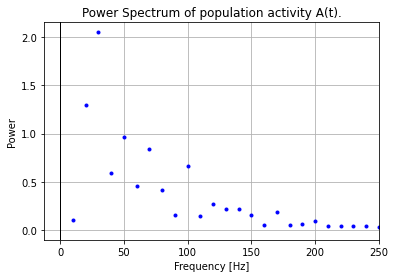

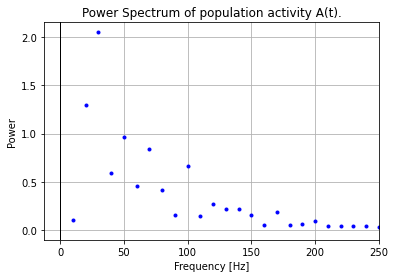

In [50]:
#                                             Power spectrum - population activity
delta_f = 10*b2.Hz; 
k = 4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = \
    spike_tools.get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**3C Answer** 

\begin{tcolorbox}[colback=green!5]
    
The Raster and Population activity plots show a very clear rhythmic spiking, with a peak of population activity reliably showing around every 30ms, the neurons in this network are clearly synchronised with a seemengly slow firing rate.

The mean firing rate observed on the smoothing windows is close to 9Hz. This slower firing rate can be attributed in a significant extense to the fact that the neurons in the network do not fire alone spontaneously as frequently as the ones shown in the previous models. 
    
The Power spectrum also makes evident the power distribution over a larger range of frequencies compared to the previous models, which had a very defined peak at a specific frequency. Here, although there is a peak close to 40Hz, the power has a slow decay from there until the 100Hz mark.
    
\end{tcolorbox}
</span>